In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import copy

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx]['input'], ", ".join(self.data[idx]['user_contacts']), self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
DEBUG = False
if DEBUG:
    train_ds.data = train_ds.data[:128]
    val_ds.data = val_ds.data[:32]

In [6]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=2, shuffle=False)

In [7]:
model = transformers.BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [8]:
from transformers.models.bart.modeling_bart import shift_tokens_right

def process_batch(batch, tokenizer):
    encoder_strs = [f'[{b}] {a}' for a,b in zip(batch[0], batch[1])]
    decoder_strs = batch[2]
    
    enc = tokenizer(encoder_strs, text_target=decoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)
#     decoder_input_ids = shift_tokens_right(enc["labels"], decoder_start_token_id=tokenizer.eos_tokenizer.pad_token_id)

#     enc['decoder_input_ids'] = copy.deepcopy(enc['labels'])
#     enc['labels'][enc['labels'] == tokenizer.pad_token_id] = -100
    
#     encoder_toks = tokenizer(encoder_strs, padding=True, truncation=True, return_tensors='pt').to(device)
#     decoder_toks = tokenizer(decoder_strs, padding=True, truncation=True, return_tensors='pt')['input_ids'].to(device)
#     decoder_toks[decoder_toks==tokenizer.pad_token_id] = -100
    return enc

In [9]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            optimizer.zero_grad()
            loss = model(**proc_batch).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        for batch in tqdm(val_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            loss = model(**proc_batch).loss

            val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

        print(f' Val Loss: {val_loss}')
        print('')

        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, (train_losses, val_losses)

In [10]:
best_model, (train_losses, val_losses) = train(model, tokenizer, train_dl, val_dl, optimizer)
torch.save(best_model, 'intent-slot-bart.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.1110401302576065


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.32314449548721313

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.06524010002613068


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.2998339533805847

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.049610842019319534


  0%|          | 0/580 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aef5d184cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aef5d184cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

 Val Loss: 0.20988792181015015

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.02018427848815918


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.19309914112091064

best model: 3
Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.022388819605112076


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.2802005708217621

Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aef5d184cb0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7aef5d184cb0>
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError: can only test a child process

  File "/opt/con

 Train Loss: 0.02223476953804493


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.27857035398483276

Epoch 6:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.01909075304865837


  0%|          | 0/580 [00:00<?, ?it/s]

 Val Loss: 0.4842841327190399



In [11]:
toks = tokenizer('[Rachel, Gordon, Harvey, Alfred] Send a text to Rachel', return_tensors='pt').to(device)
gens = model.generate(**toks)
tokenizer.decode(gens[0], ignore_special_tokens=True)

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1292: UserWarning: Using `max_length`'s default (142) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


'</s><s><s>Send_digital_object ( medium « text » object Electronic_message ( content « Send a message » ) recipient Personal_contact ( person « Rachel » ) ) modality « Send_digital-object ( person InferFromContext list_label « ) )</s>'

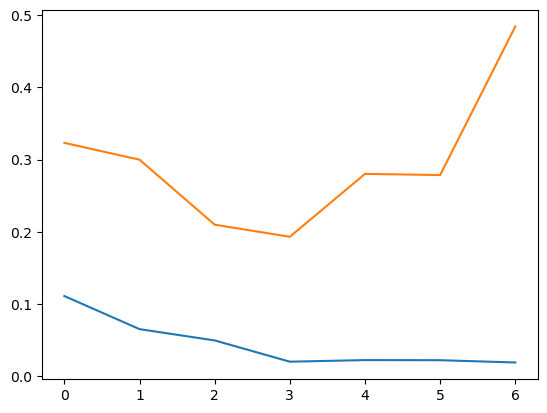

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)